# (28751) Eggl orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '28751'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0
de_kernel = 441

In [4]:
add_gaia_obs = False
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 1489 observations from the MPC.
	Filtered to 1489 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: GSC
	Unknown star catalog: UNK
	No debiasing needed for 583 observations.
	Debiased 891 observations.
	No bias information for 15 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 1391 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 297 observations.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.412			 0.518			 797.982			 0.268
2			 0.410			 0.515			 790.159			 0.266
3			 0.410			 0.515			 790.159			 0.266
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.399			 0.497			 734.392			 0.248
5			 0.400			 0.496			 734.037			 0.248
6			 0.400			 0.496			 734.037			 0.248
Converged after rejecting outliers. Rejected 4 out of 1489 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 6 (of 6):
RMS unweighted: 0.39959918173450265
RMS weighted: 0.4964741895876075
chi-squared: 734.0371571196291
reduced chi-squared: 0.24765086272592077
square root of reduced chi-squared: 0.49764531819953933
--------------------------------------------------------------
Solution Time: MJD 57771.000 TDB = 2017-01-18 00:00:00.000 TDB
Solution Observation Arc: 10730.61 days (29.38 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			1.13401656354e-01		2.69371758805e-09		1.13401636331e-01		3.73764456443e-08		-2.00231432684e-08		-7.433
q			2.23466547248e+00		5.19199077579e-09		2.23466552068e+00		9.44844370909e-08		+4.81919371076e-08		+9.282
tp			5.79393028847e+04		3.10452200867e-06		5.79393029125e+04		5.34753630079e-05		+2.77940634987e-05		+8.953
om			2.76278186645e+02		2.72949155643e-06		2.76277978965e+02		1.36295658615e

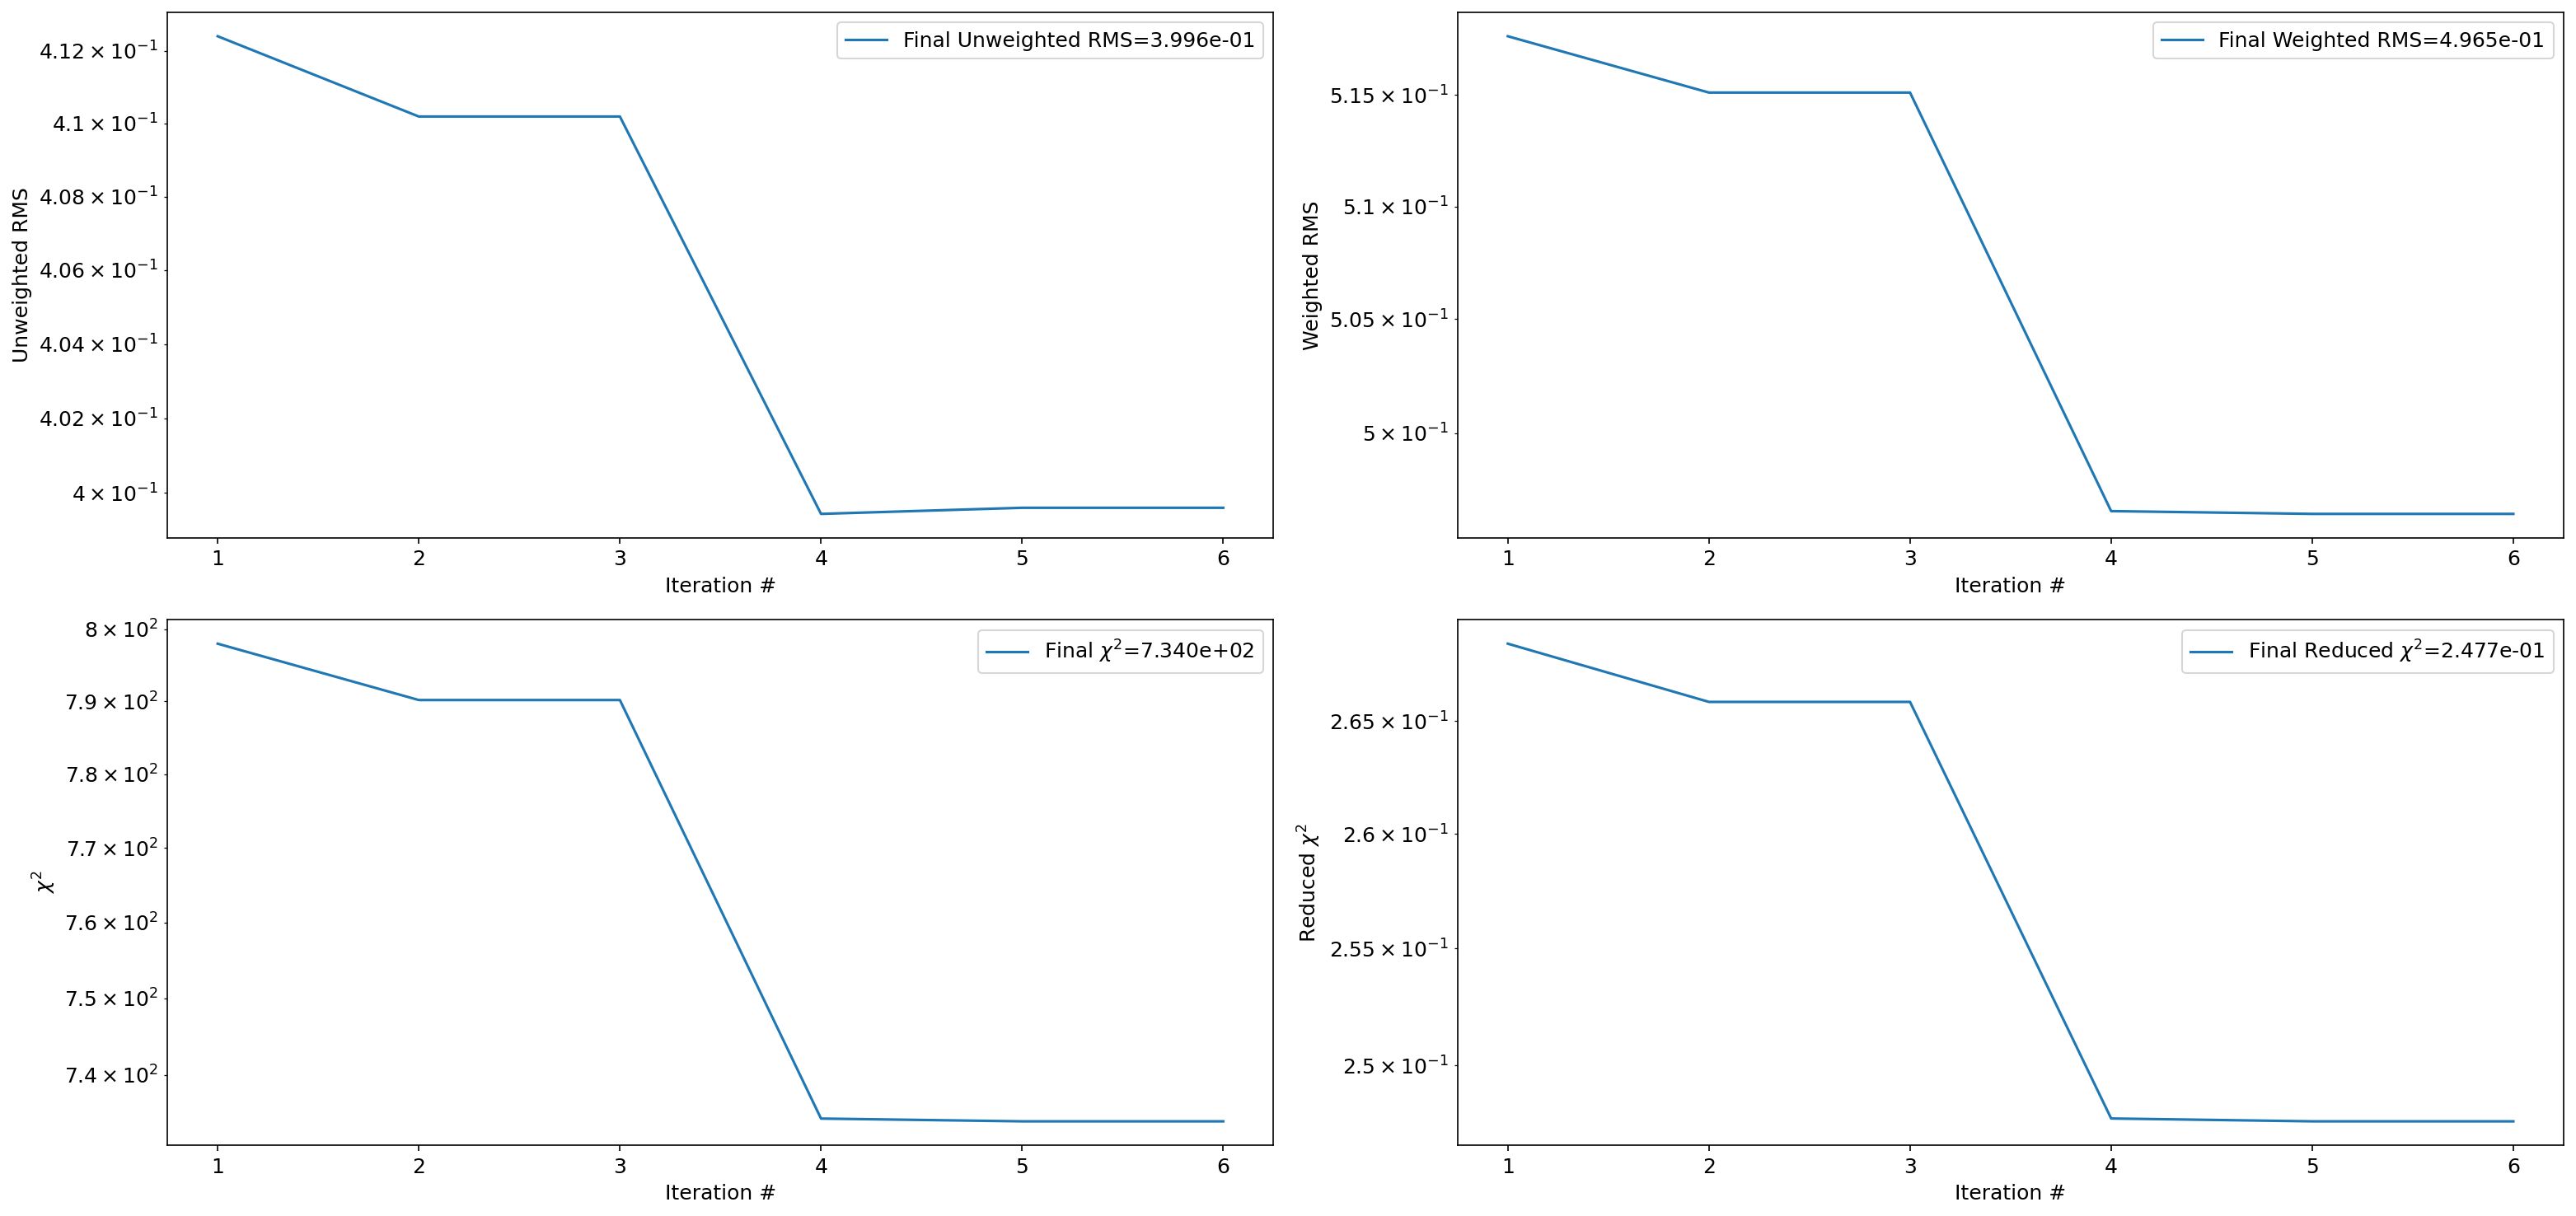

In [8]:
fit_sim.plot_summary(auto_close=True)

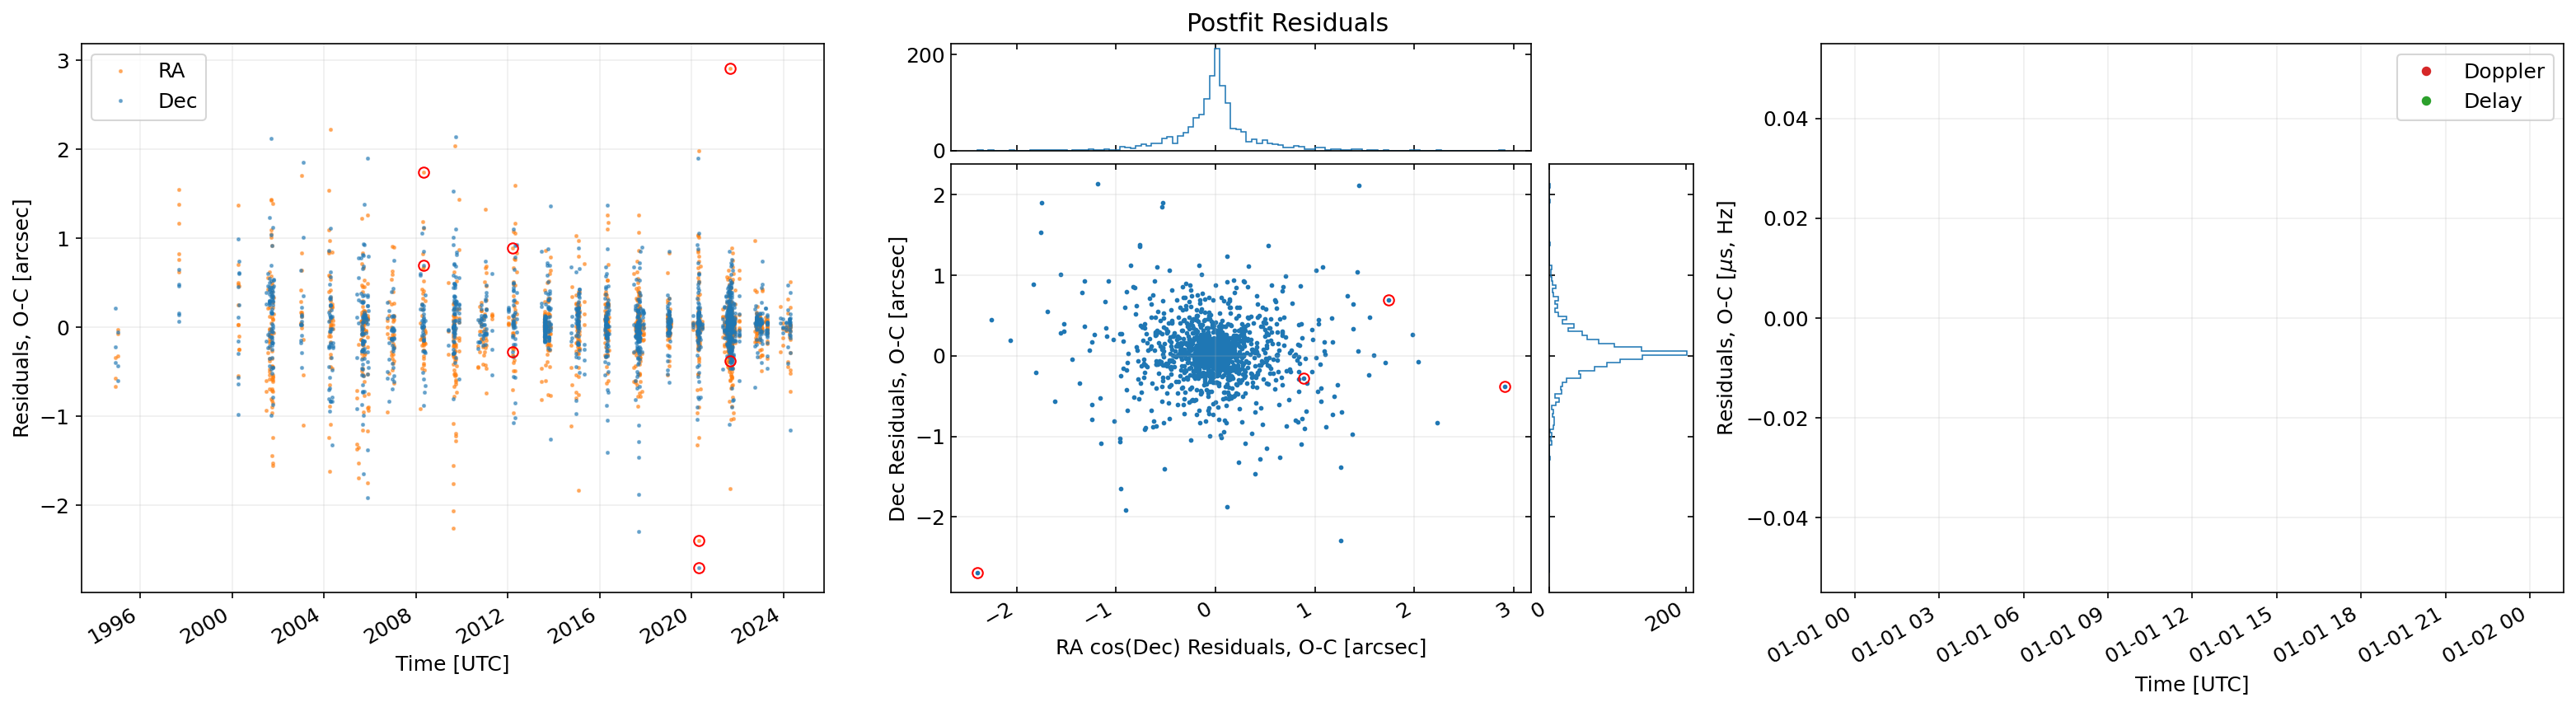

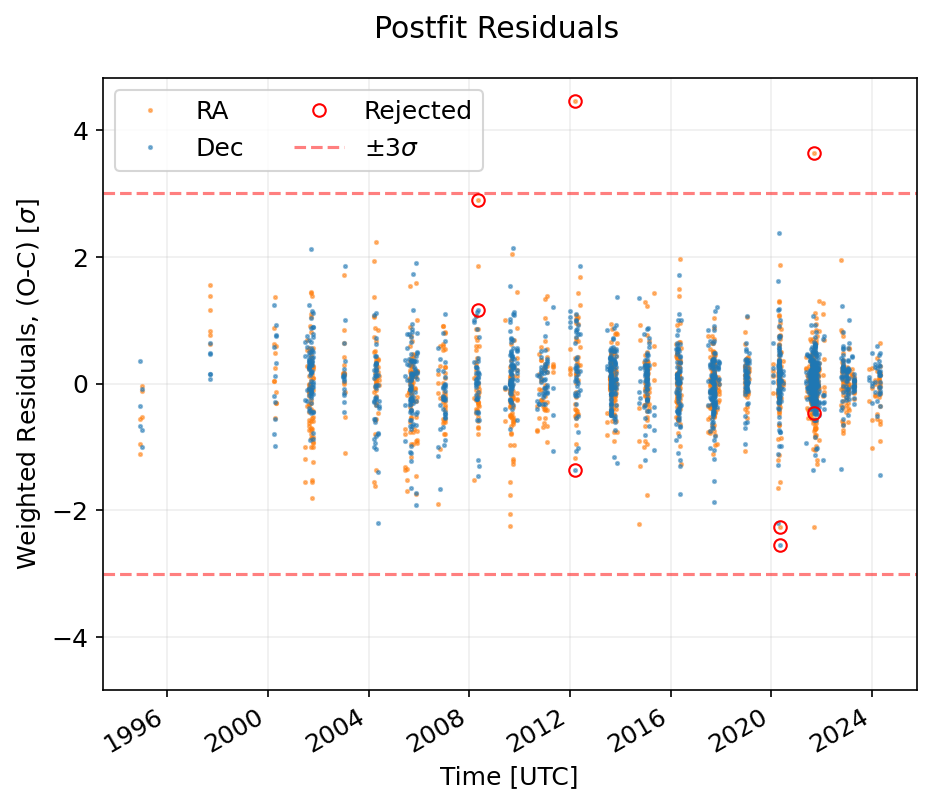

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 80.12
Mahalonobis distance between GRSS and JPL solution: 2.80
Bhattacharya distance between JPL and GRSS solution: 6.4573
Bhattacharya coefficient between JPL and GRSS solution: 0.0016


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90

AssertionError: 